$$
\dot{v_i} = v_i - \dfrac{v_i^3}{3} - w_i + I_i + D\sum\limits_{i,j} A_{ij} (v_j - v_i)  \\
\tau \dot{w_i} = v_i + a - b w_i
$$

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
from scipy.integrate import odeint

def ring(N):
    A = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)
    A[0, -1] = 1
    A[-1, 0] = 1
    return A

def fitzhugh_nagumo(state, t, A, D, a, b, eps):
    N = len(state)/2
    x, y = state.reshape(2, N)
    coupling = np.array([[j-i for j in x] for i in x])
    coupling = np.sum(A*coupling, axis=1)
    I = np.zeros(N)
    I[N/2-1: N/2+1] = 5.0 if 0.5*t % 1 < 0.2 and t < 40 else 0
    dx = x - x**3/3.0 - y + D*coupling + I
    dy = (x + a - b*y)*eps
    return np.hstack([dx, dy])

N = 200
state0 = np.zeros(2*N)
state0[:N] = -1.5
t = np.linspace(0, 150, 1500)
D, a, b, eps = 1, 0.7, 0.8, 1/12.5
A = ring(N)
args = (A, D, a, b, eps)
res = odeint(fitzhugh_nagumo, state0, t, args=args)
res_ani = res[:, :]     # for animation
res = res[400:, :]      # cut off the initial pumping phase

/home/happyling/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/happyling/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/happyling/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [3]:
# http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
from tempfile import NamedTemporaryFile
from IPython.display import HTML
import matplotlib.animation as animation

def anim_to_html(anim):
    
    VIDEO_TAG = """<video controls>
    <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>"""
    
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))



In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.axes(xlim=(0-150, N-151), ylim=(np.min(res[:, :N]), np.max(res[:, :N])))
ax.set_xlabel(r"space $i$")
ax.set_ylabel(r"$v_i$")
ax.set_title("n =0 ")

line, = ax.plot([], [], 'o')
plt.tight_layout()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.arange(N) - 150
    y = res_ani[i, :N]
    line.set_data(x, y)
    ax.set_title("n = %i" % i)
    return line,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=res_ani.shape[0], interval=15, blit=True)
display_animation(ani)

/home/happyling/anaconda3/lib/python3.5/site-packages/matplotlib/animation.py:784: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: Cannot save animation: no writers are available. Please install mencoder or ffmpeg to save animations.

### Prepare the data

In [5]:
import pandas as pd

def prepare_data(res, space_sampling, time_delays):
    data = pd.DataFrame()
    names = []
    dt = 0.1 
    start = 250
    tau = 200*dt
    center = 150

    for dx in space_sampling:
        for dt in time_delays:

            name = "v{0}_{1}".format(-dx, dt)
            names.append(name)
            data[name] = res[start-dt:-dt-tau, center+dx]

    data['v_tau'] = res[start+tau:, center]

    data = (data - data.min() )/ (data.max() - data.min())
    return data, names

def split(data, names):
    train = data[:]
    target = train.pop('v_tau').as_matrix()
    train = train.as_matrix()
    varnames = names[:]
    return train, target, varnames

zero_sampling = [0]
time_delays = [0, 10, 20, 30, 40]
space_sampling = [0, -2, -4, -6, -8, -10, -20]

site_only = prepare_data(res, zero_sampling, time_delays)
spatial_extended = prepare_data(res, space_sampling, zero_sampling)
mixed = prepare_data(res, space_sampling, time_delays)

samplings = [site_only, spatial_extended, mixed]
sampling_name = ["site only", "spatial extended", "mixed"]

reg_input =  list(map(split, *zip(*samplings)))

/home/happyling/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/happyling/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
np.shape(reg_input)

(3, 3)

In [7]:
import ffx
ffx.core.CONSIDER_THRESH = False

def run_ffx(data, target, varnames):
    train_X = data[::2]
    train_y = target[::2]
    test_X = data[1::2]
    test_y = target[1::2]
    models = ffx.run(train_X, train_y, test_X, test_y, varnames=varnames)
    
    base = [model.numBases() for model in models]
    test_error = [model.test_nmse for model in models]
    train_error = [ffx.core.nmse(model.simulate(train_X), train_y, min(target), max(target))
                           for model in models]
    
    return [base, test_error], [base, train_error], models

In [8]:
ffx_results = map(lambda x: run_ffx(*x), reg_input)
ffx_results = list(ffx_results)

/home/happyling/anaconda3/lib/python3.5/site-packages/ffx/core.py:865: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  st, fin, num=ss.numAlphas() * 10)[::-1][:ss.numAlphas() / 4]
/home/happyling/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


site only -0.0273 + 3.34*v0_0 - 2.41*v0_0 * v0_10 - 2.09*v0_40 * v0_10 + 1.64*v0_20^2 - 1.53*v0_20 - 1.16*v0_10 + 0.991*v0_30^2 + 0.684*v0_0^2 + 0.463*v0_30 + 0.433*v0_20 * v0_0 + 0.373*v0_20 * v0_10 - 0.359*v0_40^2 + 0.216*v0_40 + 0.00286*v0_10^2

spatial extended -0.00247 + 0.897*v2_0 + 0.178*v0_0 - 0.0650*v4_0 + 0.00280*v10_0 - 0.00210*v8_0

mixed 0.00894 + 0.442*v4_30 + 0.346*v2_10 + 0.175*v2_0



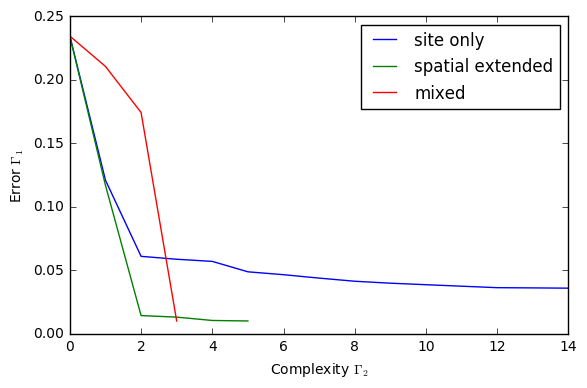

In [9]:
##plt.style.use('style.mplstyle')

for result, name in zip(ffx_results, sampling_name):
    front, front_train, front_models = result
    comp, error = front
    print(name, str(front_models[-1]))
    print()
    plt.plot(comp, error, label=name)
plt.xlabel(r"Complexity $\Gamma_2$")
plt.ylabel(r"Error $\Gamma_1$")
plt.legend()
plt.tight_layout()

-0.0273 + 3.34*v0_0 - 2.41*v0_0 * v0_10 - 2.09*v0_40 * v0_10 + 1.64*v0_20^2 - 1.53*v0_20 - 1.16*v0_10 + 0.991*v0_30^2 + 0.684*v0_0^2 + 0.463*v0_30 + 0.433*v0_20 * v0_0 + 0.373*v0_20 * v0_10 - 0.359*v0_40^2 + 0.216*v0_40 + 0.00286*v0_10^2 14 0.03572564386390949
-0.00247 + 0.897*v2_0 + 0.178*v0_0 - 0.0650*v4_0 + 0.00280*v10_0 - 0.00210*v8_0 5 0.00987989211514151
0.00894 + 0.442*v4_30 + 0.346*v2_10 + 0.175*v2_0 3 0.009842030330692317


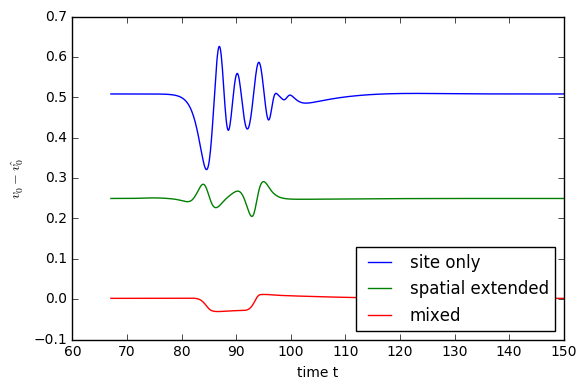

In [11]:
for result, input_, name, i in zip(ffx_results, reg_input, sampling_name, [0.5, 0.25, 0.0]):
    front, front_train, front_models = result
    model = front_models[-1]
    print(model, model.numBases(), model.test_nmse)
    train = input_[0]
    
    target = input_[1]
    delta = len(t) - len(train)
    plt.plot(t[delta:], model.simulate(train) - target + i, ms=0, label=name)
    
plt.xlabel(r"time t")
plt.ylabel(r"$v_0 - \hat{v_0}$")
plt.legend(loc=4)
plt.tight_layout()

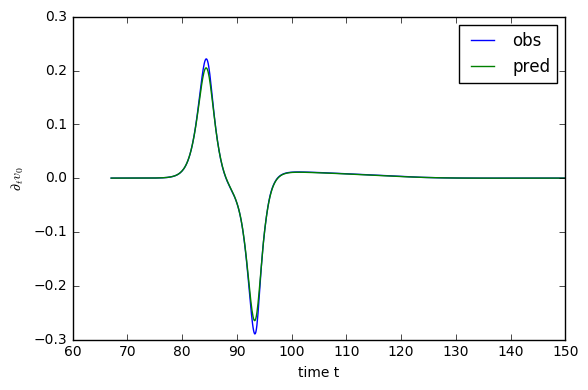

In [12]:
model = ffx_results[-1][-1][-1]

def gradient1d(x, y):
    return np.gradient(y, np.gradient(x))

plt.plot(t[delta:], gradient1d(t[delta:], target), ms=3, label="obs")
plt.plot(t[delta:], gradient1d(t[delta:], model.simulate(train)), ms=3, label="pred")
plt.xlabel(r"time t")
plt.ylabel(r"$\partial_t v_0$")
plt.legend()
plt.tight_layout()

In [13]:
from deap import base
from deap import creator
from deap import tools
from deap import gp

class MyGPTree(gp.PrimitiveTree):

    def __init__(self, content, op=str):
        gp.PrimitiveTree.__init__(self, content)
        self.op = op

    def __hash__(self):
        return hash(self.op(self))

    def __eq__(self, other):
        return self.op(self) == self.op(other)


def remove_twins(pop):
    return list(set(pop))

In [14]:
def _div(left, right):
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 0
            x[np.isnan(x)] = 0
        elif np.isinf(x) or np.isnan(x):
            x = 0
    return x

def _pow(y, n=1):
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.power(y, n)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 0
            x[np.isnan(x)] = 0
        elif np.isinf(x) or np.isnan(x):
            x = 0
    return x

def _log(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.log(x)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

def _sqrt(x):
    with np.errstate(invalid='ignore'):
        x = np.sqrt(x)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 0
            x[np.isnan(x)] = 0
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

def prepare_funcset(strat, n):
    funcset = gp.PrimitiveSet("MAIN", n)

    funcset.addPrimitive(np.add, 2, name="Add")
    funcset.addPrimitive(np.subtract, 2, name="Sub")
    funcset.addPrimitive(np.multiply, 2, name="Mul")
    funcset.addPrimitive(_div, 2, name="Div")

    if "symc" in strat:
        id_ = len([x for x in dir(gp) if "symc" in x])   # number of instances of symc Ephemeral class
        funcset.addEphemeralConstant("symc{}".format(id_), lambda: 1.0)

    if "pot" in strat:
        funcset.addPrimitive(np.square, 1, name="square")
        funcset.addPrimitive(_sqrt, 1, name="sqrt")
    if "exp" in strat:
        funcset.addPrimitive(np.exp, 1, name="exp")
        funcset.addPrimitive(_log, 1, name="log")
    if "trigo" in strat:
        funcset.addPrimitive(np.sin, 1, name="sin")
        funcset.addPrimitive(np.cos, 1, name="cos")
        
    return funcset

In [15]:
import scipy.optimize as opt
import copy


def generate_context(pset, data):
    context = {arg: dat for arg, dat in zip(pset.arguments, data.T)}
    context.update(pset.context)

    return context


def optimize_constants(ind, cost, context, precision=3, options=None, constraints=None):
    """ Update the constant values of ind according to:
    vec(c) = argmin_c ||yhat(data,c) - y||

    This needs to be called together when using symbolic constants.
    It may be called as a mutation operator together with the usage of ercs.
    """
    idx = [index for index, node in enumerate(ind) if isinstance(node, gp.Ephemeral)]

    if len(idx) == 0:
        return ind

    values = [ind[i].value for i in idx]
    values_bak = copy.copy(values)
    args = [("c%i" % i) for i in range(len(idx))]

    code = str(ind)
    for i, arg in zip(idx, args):
        code = code.replace(ind[i].format(), arg, 1)
    code = "lambda {args}: {code}".format(args=",".join(args), code=code)
    yhat = eval(code, context, {})
    with np.errstate(invalid='ignore', over='ignore'):
        res = opt.minimize(cost, values, args=yhat, options=options, constraints=constraints)

    if res.success and all(np.isfinite(res.x)):
        values = res.x
    else:
        values = values_bak

    for i, value in zip(idx, values):
        ind[i] = type(ind[i])()
        ind[i].value = round(value, 3)

    return ind

In [16]:
import re
from sympy import simplify, lambdify

def convert_inverse_prim(prim, args):
    """
    Convert inverse prims according to:
    [Dd]iv(a,b) -> Mul[a, 1/b]
    [Ss]ub(a,b) -> Add[a, -b]

    We achieve this by overwriting the corresponding format method of the sub and div prim.
    """

    prim.name = re.sub(r'([A-Z])', lambda pat: pat.group(1).lower(), prim.name)    #lower all capital letters

    converter = {
        'sub': lambda *args_: "Add({}, Mul(-1,{}))".format(*args_),
        'div': lambda *args_: "Mul({}, Pow({}, -1))".format(*args_)
    }
    prim_formatter = converter.get(prim.name, prim.format)

    return prim_formatter(*args)


def stringify_for_sympy(f):
    """Return the expression in a human readable string.
    """
    string = ""
    stack = []
    for node in f:
        stack.append((node, []))
        while len(stack[-1][1]) == stack[-1][0].arity:
            prim, args = stack.pop()
            string = convert_inverse_prim(prim, args)
            if len(stack) == 0:
                break  # If stack is empty, all nodes should have been seen
            stack[-1][1].append(string)
    return string


def simplify_this(expr):
    return simplify(stringify_for_sympy(expr))


In [38]:
import operator

hyper = {'gen': 50, 'mu': 500, 'cxpb': 0.5}

def run_gp(data, target, varnames, hyper=hyper):
    train_X = data[::2]
    train_y = target[::2]
    test_X = data[1::2]
    test_y = target[1::2]
    
    funcset = prepare_funcset(["exp", "symc", "pot", "trigo"], data.shape[1])
    
    new_varnames = {'ARG%i' % i: var for i, var in enumerate(varnames)}
    funcset.renameArguments(**new_varnames)
    
    toolbox = base.Toolbox()
    toolbox.register("compile", gp.compile, pset=funcset)
    
    def error_(ind, compile, y, X):
        model = compile(expr=ind)
        yhat = model(*X.T)
        return np.sqrt(np.nanmean((y-yhat)**2))
    
    error = lambda ind: error_(ind, toolbox.compile, train_y, train_X)
    finalize = lambda ind: error_(ind, toolbox.compile, test_y, test_X)
    
    def _evaluate(ind):
        return error(ind), len(ind)
    
    optimize_options = {'maxiter': 5}
    cons = ({'type': 'ineq', 'fun': lambda x: 10.0-np.abs(x)})
    context = generate_context(funcset, train_X)
    cost = lambda args, yhat: np.sum((train_y - yhat(*args))**2)
    
    optimize = lambda ind: optimize_constants(ind, cost=cost, context=context,
                                              options=optimize_options, constraints=cons)
    
    creator.create("Fitness", base.Fitness, weights=(-1.0, -1.0))
    creator.create("Individual", MyGPTree, fitness=creator.Fitness)

    toolbox.register("expr", gp.genHalfAndHalf, pset=funcset, min_=1, max_=4)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA2)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=funcset)

    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

    toolbox.register("evaluate", _evaluate)
    
    def evolve(toolbox, seed=seed, gen=0, mu=1, lambda_=1, cxpb=1, mutp=0):
        random.seed(seed)
        np.random.seed(seed)

        pop = remove_twins(toolbox.population(n=mu))
        pop = list(toolbox.map(optimize, pop))

        invalid_ind = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = list(toolbox.map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            
            ind.fitness.values = fit

        pop = toolbox.select(pop, mu)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.nanmin, axis=0)
        stats.register("max", np.nanmax, axis=0)
        stats.register("diversity", lambda pop: len(set(map(str, pop))))

        logbook = tools.Logbook()
        logbook.header = "gen", "evals", "min", "max", "diversity"

        record = stats.compile(pop)
        logbook.record(gen=0, evals=len(invalid_ind), **record)
        print(logbook.stream)
        if record['min'][0] == 0.0:
            return pop, logbook

        for gen in range(1, gen):
            offspring = tools.selRandom(pop, mu)
            offspring = [toolbox.clone(ind) for ind in offspring]

            for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
                if random.random() <= cxpb:
                    toolbox.mate(ind1, ind2)

                toolbox.mutate(ind1)
                toolbox.mutate(ind2)
                del ind1.fitness.values, ind2.fitness.values

            offspring = list(toolbox.map(optimize, offspring))

            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = list(toolbox.map(toolbox.evaluate, invalid_ind))
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            pop = toolbox.select(remove_twins(pop+offspring), mu)
            record = stats.compile(pop)
            logbook.record(gen=gen, evals=len(invalid_ind), **record)

            print(logbook.stream)
            if record['min'][0] < 1E-4:
                break

        return pop, logbook
    
    pop, log = evolve(toolbox, **hyper)
    
    pareto = tools.ParetoFront()
    pareto.update(pop)
    
    train_error = np.array([ind.fitness.values[0] for ind in pareto])  # store so we can quickly access this

    fitnesses = list(toolbox.map(finalize, pareto))
    for ind, fit in zip(pareto, fitnesses):
            ind.fitness.values = fit, len(ind)
    
    error, complexity = map(np.array, zip(*[ind.fitness.values for ind in pareto]))
    models_compiled = [toolbox.compile(m) for m in pareto]
    return [complexity, error], [complexity, train_error], pareto, models_compiled

In [33]:
gp_results = map(lambda x: run_gp(*x), reg_input)

In [34]:
data,target,varname = reg_input[1]

In [35]:
data.shape[1]

7

In [36]:
gp_results = list(gp_results)

gen	evals	min                      	max        	diversity
0  	401  	[ 0.11444102  2.        ]	[ inf  21.]	378      
1  	500  	[ 0.11444102  1.        ]	[  2.48803797  23.        ]	454      
2  	500  	[ 0.08864531  1.        ]	[  2.48803797  21.        ]	417      
3  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	432      
4  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	437      
5  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	428      
6  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	423      
7  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	428      
8  	500  	[ 0.0765771  1.       ]  	[  2.48803797  19.        ]	431      
9  	500  	[ 0.07540742  1.        ]	[  2.48803797  19.        ]	423      
10 	500  	[ 0.07540742  1.        ]	[  2.48803797  20.        ]	421      
11 	500  	[ 0.07540742  1.        ]	[  2.48803797  20.        ]	418      
12 	500  	[ 0.07540742  1.        ]	[  2.48803797  19.        ]	419   

gen	evals	min                      	max        	diversity
0  	401  	[ 0.11444102  2.        ]	[ inf  21.]	378      
1  	500  	[ 0.11444102  1.        ]	[  2.48803797  23.        ]	454      
2  	500  	[ 0.08864531  1.        ]	[  2.48803797  21.        ]	417      
3  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	432      
4  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	437      
5  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	428      
6  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	423      
7  	500  	[ 0.08863007  1.        ]	[  2.48803797  19.        ]	428      
8  	500  	[ 0.0765771  1.       ]  	[  2.48803797  19.        ]	431      
9  	500  	[ 0.07540742  1.        ]	[  2.48803797  19.        ]	423      
10 	500  	[ 0.07540742  1.        ]	[  2.48803797  20.        ]	421      
11 	500  	[ 0.07540742  1.        ]	[  2.48803797  20.        ]	418      
12 	500  	[ 0.07540742  1.        ]	[  2.48803797  19.        ]	419   

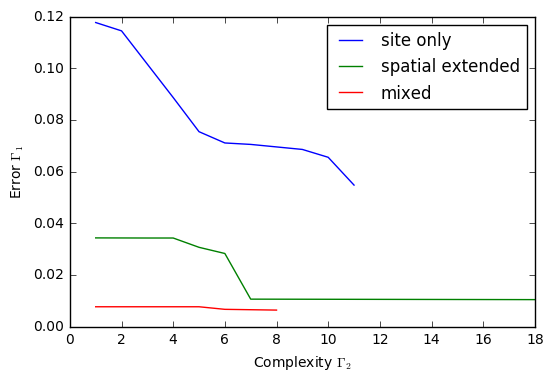

In [30]:
for result, name in zip(gp_results, sampling_name):
    front, front_train, front_models, _ = result
    comp, error = front
    plt.plot(comp, error, label=name)
    model = front_models[0]
    print(simplify_this(model))
    
plt.xlabel(r"Complexity $\Gamma_2$")
plt.ylabel(r"Error $\Gamma_1$")
plt.legend()

In [43]:
test = reg_input[1]
test[0]
np.shape(test[0])

(830, 7)

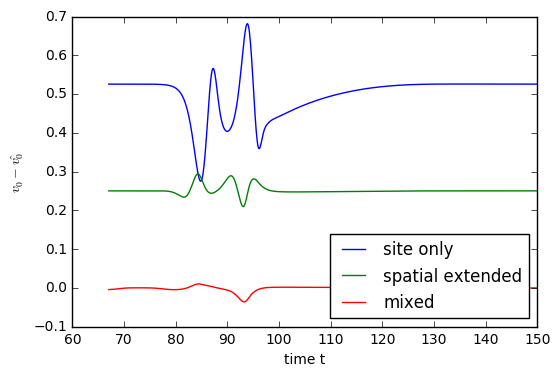

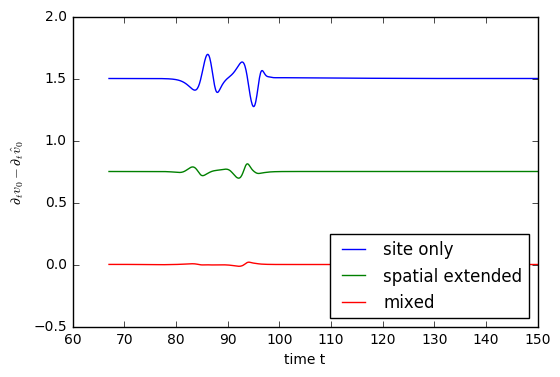

In [37]:
fig1 = plt.figure(0)
fig2 = plt.figure(1)

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)


deriv = gradient1d(t[delta:], target)
for result, input_, name, i in zip(gp_results, reg_input, sampling_name, [0.5, 0.25, 0.0]):
    front, front_train, models, models_bin = result
    model = models_bin[0]
    train = input_[0]
    
    target = input_[1]
    delta = len(t) - len(train)
    ax1.plot(t[delta:], model(*train.T) - target + i, label=name, ms=0)
    ax2.plot(t[delta:], gradient1d(t[delta:], model(*train.T)) - deriv + 3*i, label=name, ms=0)
    
ax1.set_xlabel(r"time t")
ax1.set_ylabel(r"$v_0 - \hat{v_0}$")
ax1.legend(loc=4)

ax2.set_xlabel(r"time t")
ax2.set_ylabel(r"$\partial_t v_0 - \partial_t \hat{v}_0$")
ax2.legend(loc=4)